### Import Libraries

In [1]:
import warnings
import pandas as pd
import numpy as np
import time
import seaborn as sns
import matplotlib
import matplotlib.pylab as plt
import pandas_profiling

import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from imblearn.over_sampling import SMOTE

pd.set_option('max_columns', None)

warnings.filterwarnings("ignore")

%matplotlib inline

### Load Dataset

In [2]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

### Explore Dataset

In [3]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
df.shape

(7043, 21)

In [5]:
df.isna().any()

customerID          False
gender              False
SeniorCitizen       False
Partner             False
Dependents          False
tenure              False
PhoneService        False
MultipleLines       False
InternetService     False
OnlineSecurity      False
OnlineBackup        False
DeviceProtection    False
TechSupport         False
StreamingTV         False
StreamingMovies     False
Contract            False
PaperlessBilling    False
PaymentMethod       False
MonthlyCharges      False
TotalCharges        False
Churn               False
dtype: bool

In [6]:
df['Churn'].value_counts()

No     5174
Yes    1869
Name: Churn, dtype: int64

In [7]:
df['PaymentMethod'].value_counts()

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64

In [8]:
df['Contract'].value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: Contract, dtype: int64

### Data Cleaning 

In [3]:
df = df.drop(['customerID'], axis=1)

In [5]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors="coerce")

In [6]:
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

### Visualize Data

#### Customer Distribution 

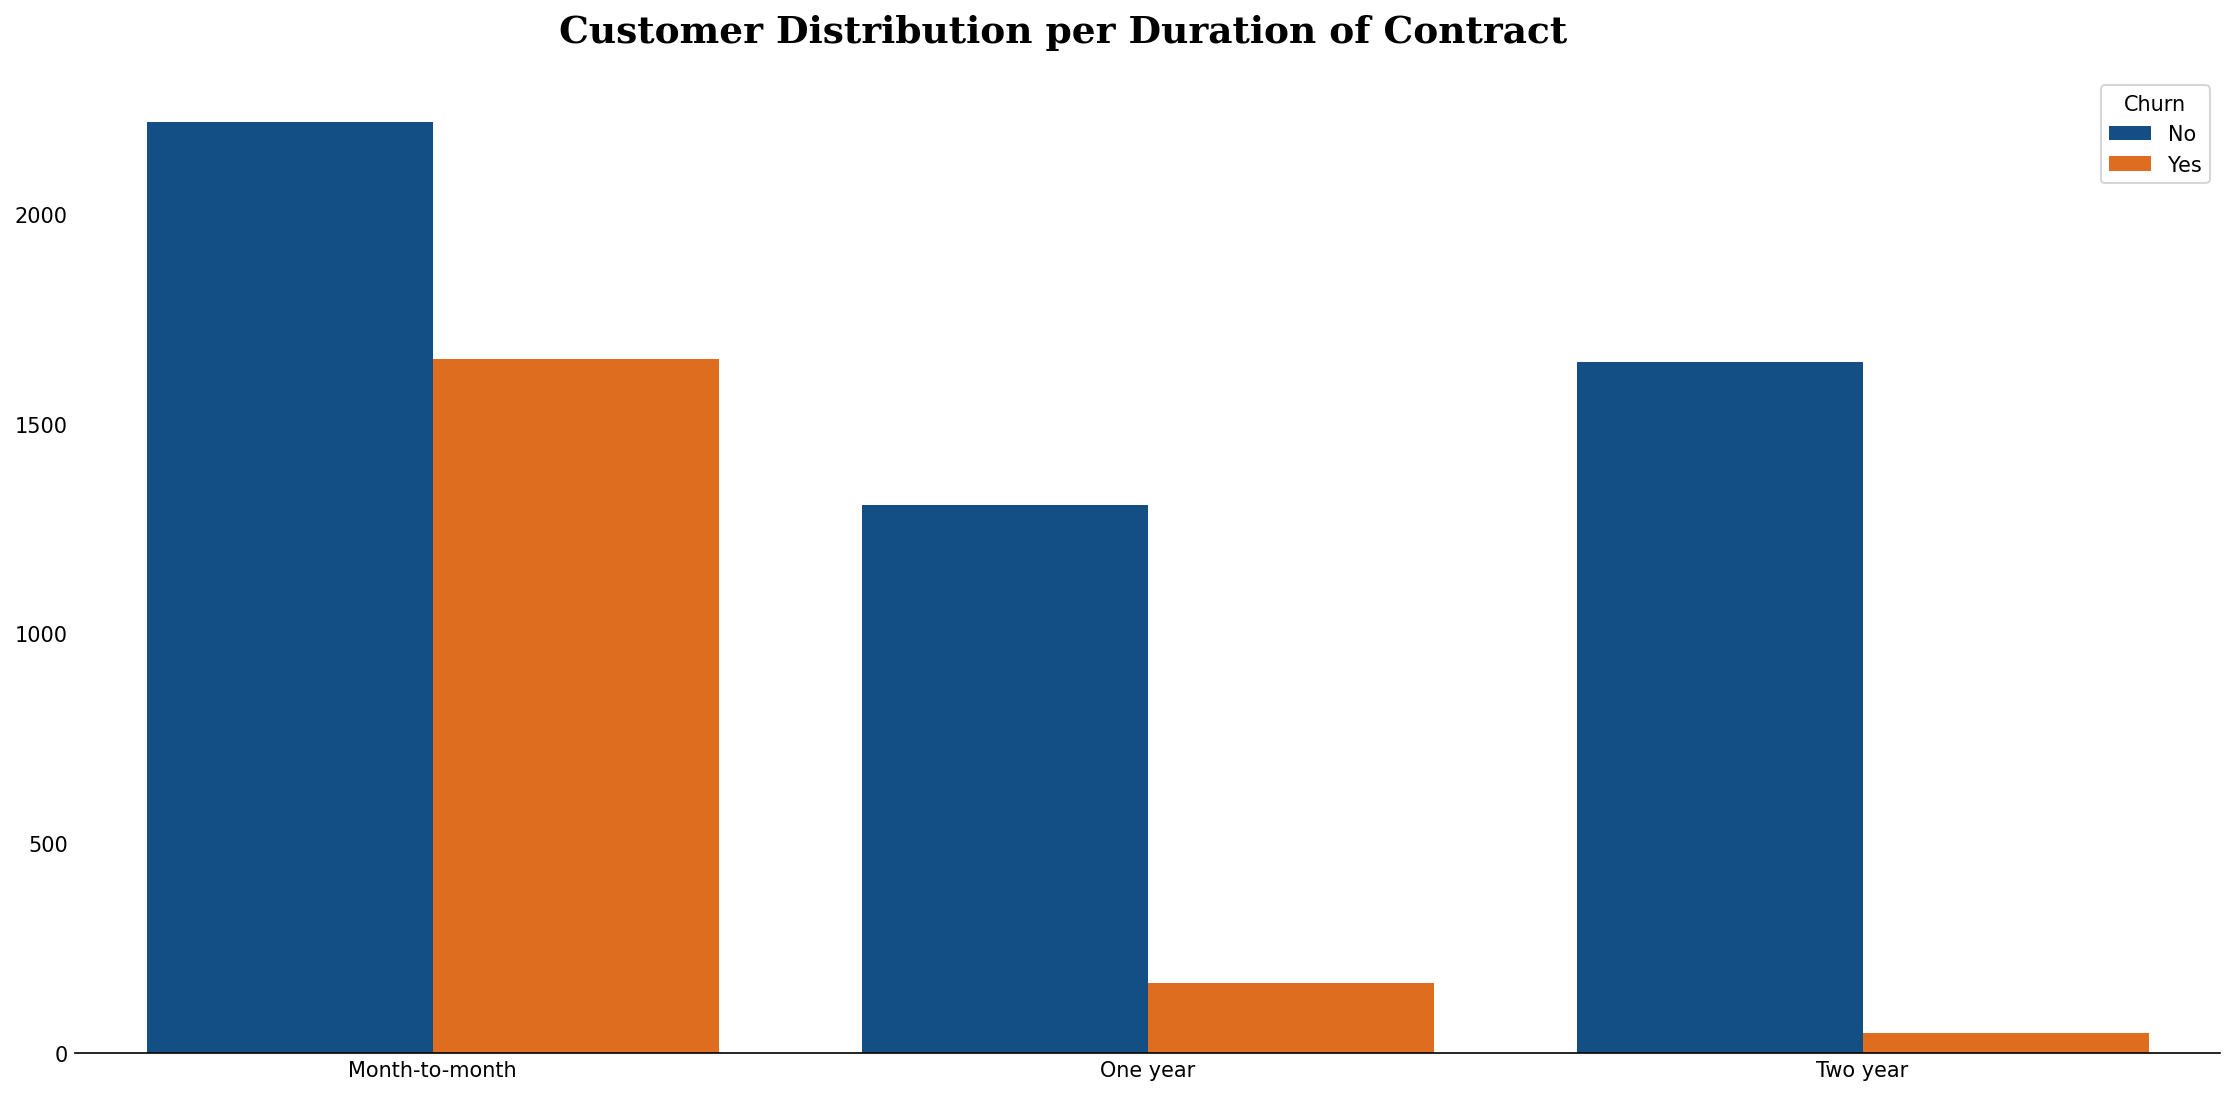

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7), dpi=150)

color = ["#004E98","#FF6700"]



sns.countplot(data=df,
              x='Contract',
              hue='Churn',
              order=['Month-to-month', 'One year', 'Two year'],
             palette=color)

for s in ['top', 'left', 'right']:
    ax.spines[s].set_visible(False)

ax.set_ylabel('')
ax.set_xlabel('')

ax.tick_params(axis=u'both', which=u'both', length=0)

fig.text(0.7,
         1.01,
         'Customer Distribution per Duration of Contract',
         fontweight='bold',
         fontfamily='serif',
         fontsize=18,
         ha='right')

plt.tight_layout()
plt.show()

#### Customer Tenure Distribution

In [9]:
def ten_cat(tenure):

    if tenure >= 0 and tenure < 10:
        return '0-10'
    if tenure >= 10 and tenure < 20:
        return '10-20'
    if tenure >= 20 and tenure < 30:
        return '20-30'
    if tenure >= 30 and tenure < 40:
        return '30-40'
    if tenure >= 40 and tenure < 50:
        return '40-50'
    if tenure >= 50 and tenure < 60:
        return '50-60'
    if tenure >= 60 and tenure < 70:
        return '60-70'
    else:
        return '70+'

In [10]:
ten_df = df

In [11]:
ten_df['tenure'] = ten_df.tenure.apply(lambda x: ten_cat(x))

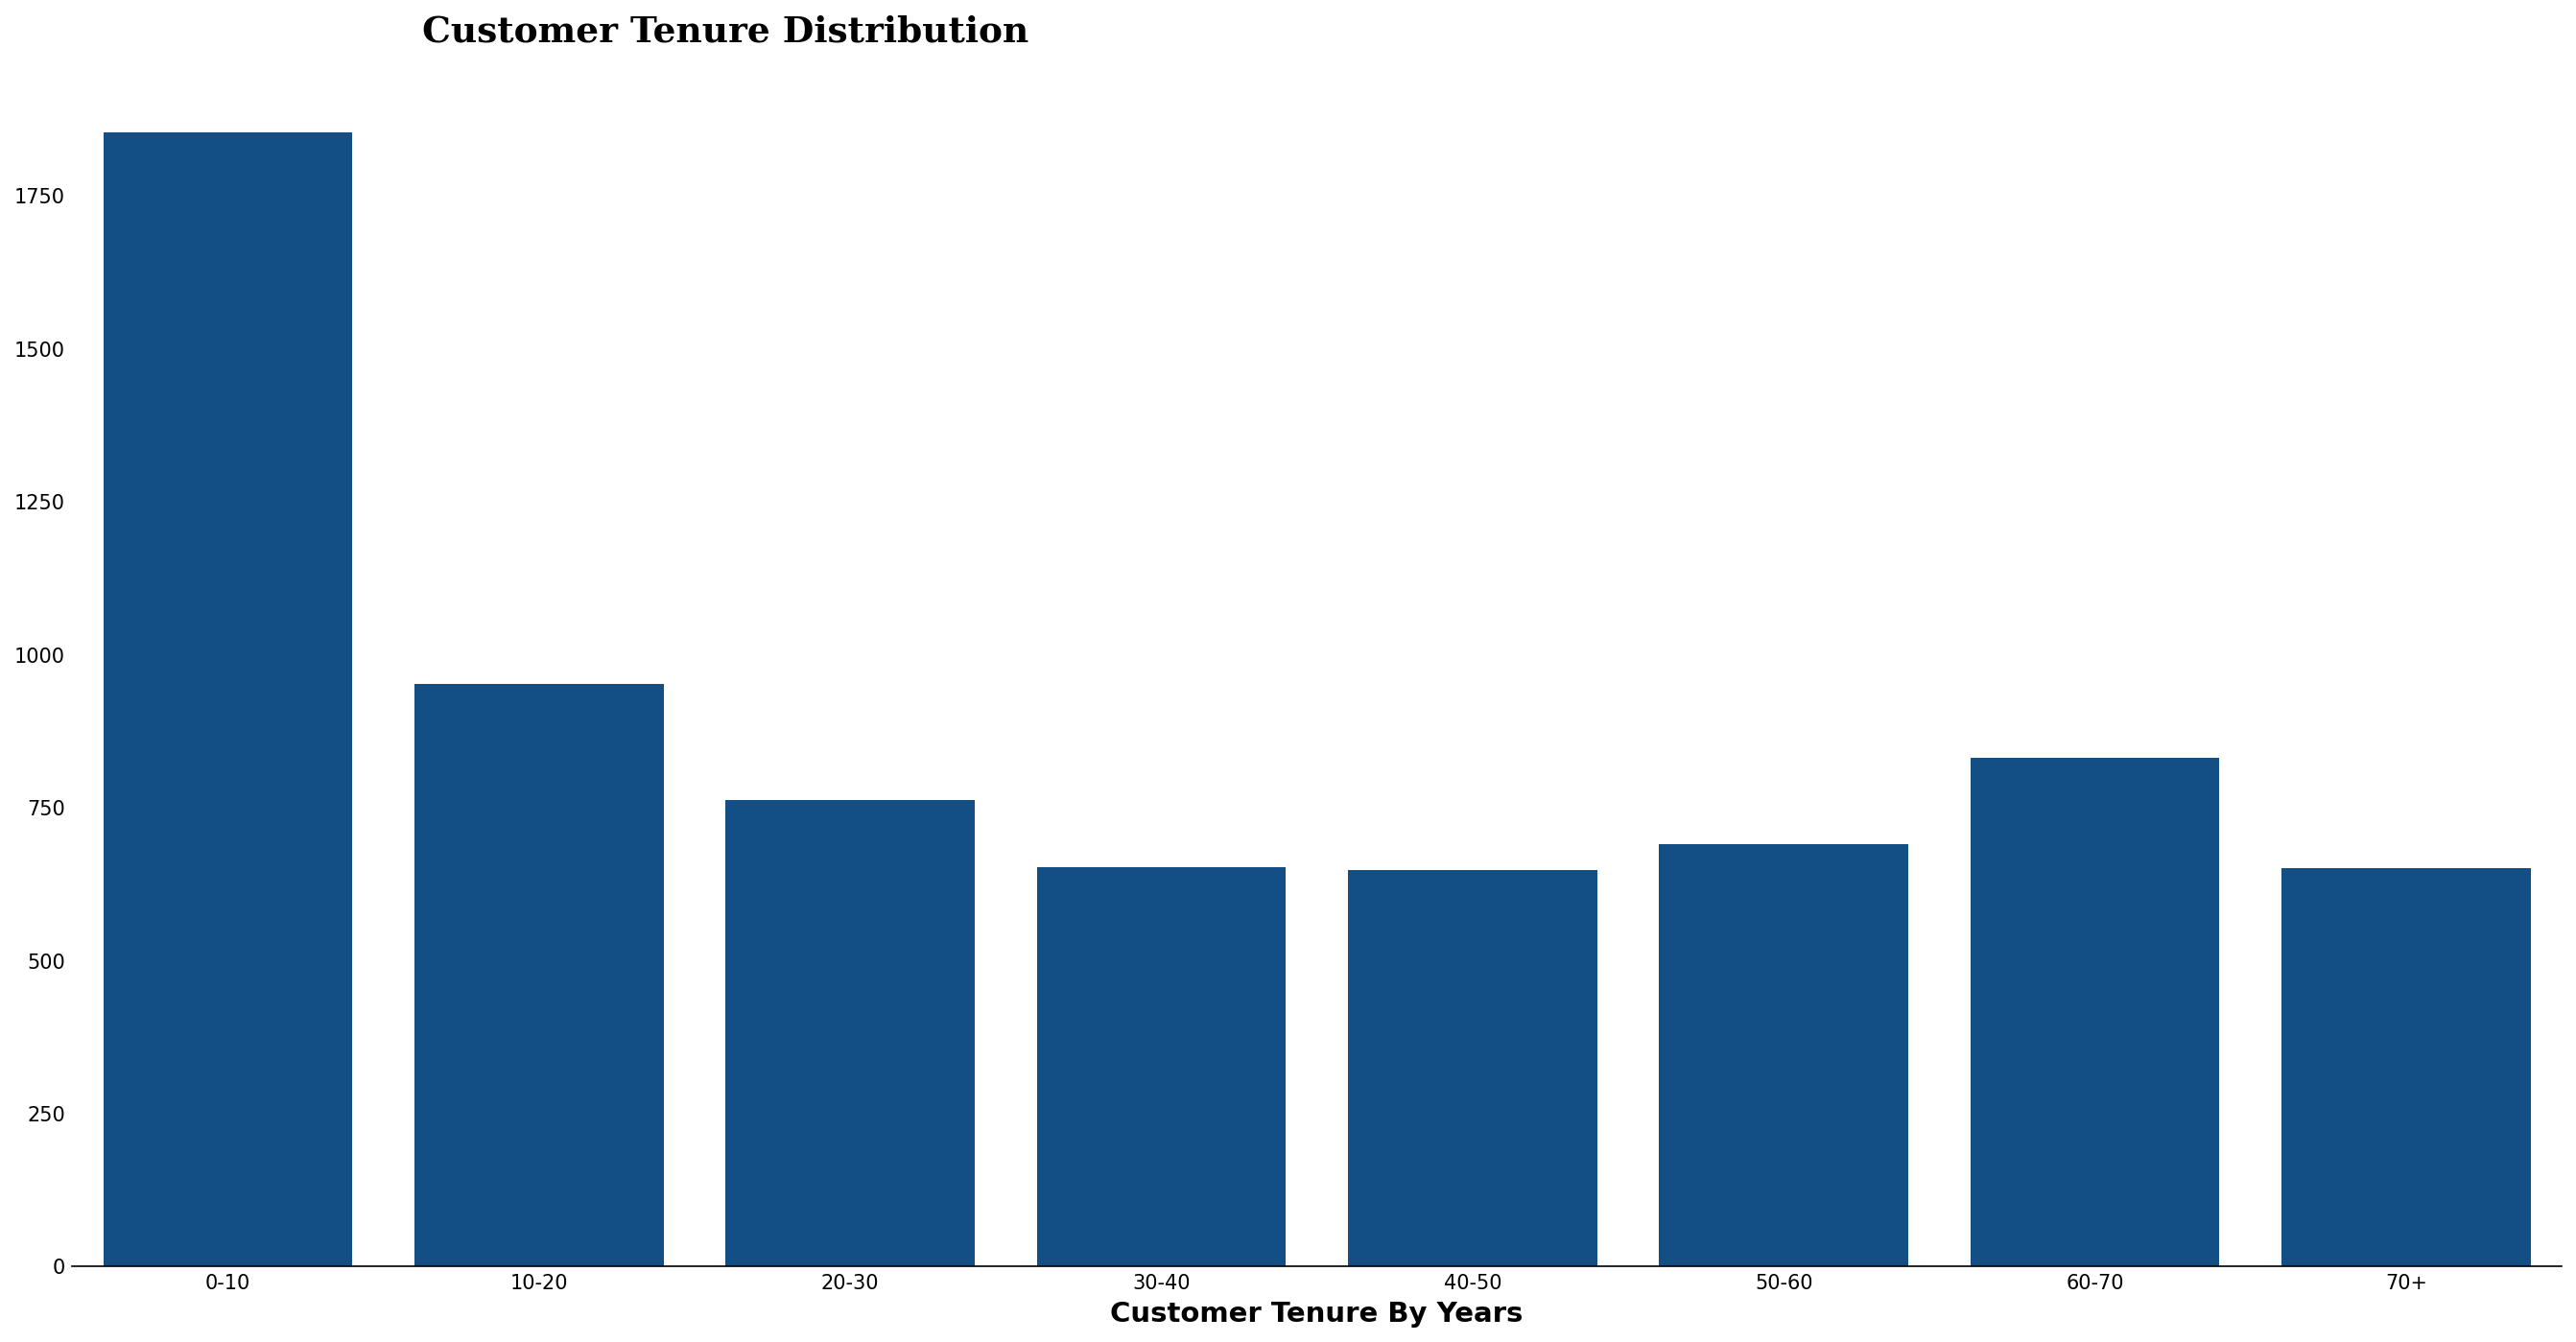

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(18, 9), dpi=150)

sns.countplot(data=ten_df,
              x='tenure',
              order=[
                  '0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70',
                  '70+'
              ],
              color='#004E98')

fig.text(0.4,
         1.01,
         'Customer Tenure Distribution',
         fontweight='bold',
         fontfamily='serif',
         fontsize=18,
         ha='right')

ax.set_ylabel('')
ax.set_xlabel('Customer Tenure By Years', fontsize=14, fontweight='bold')

for s in ['top', 'left', 'right']:
    ax.spines[s].set_visible(False)

ax.tick_params(axis=u'both', which=u'both', length=0)

plt.tight_layout()
plt.show()

#### Gender Count

In [35]:
gender = df.gender.value_counts().reset_index()
gender.columns = ['Gender', 'Count']

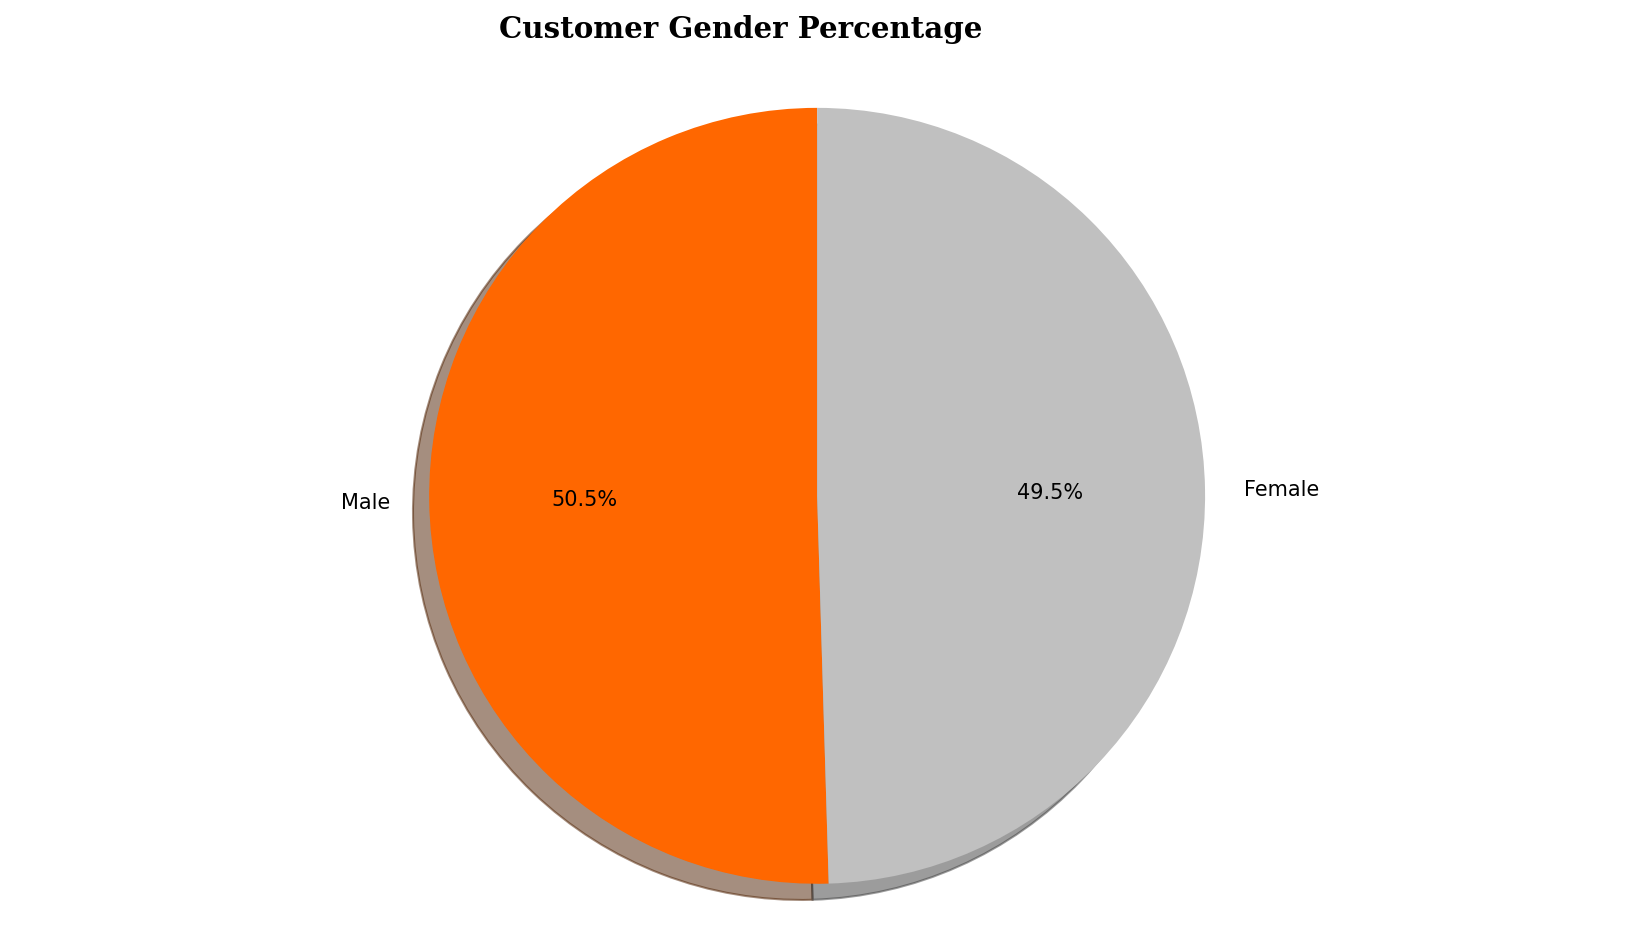

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(11, 6), dpi=150)

color = ["#FF6700", "#C0C0C0"]
ax.pie(gender['Count'],
       labels=gender.Gender,
       autopct='%1.1f%%',
       shadow=True,
       startangle=90,
       colors=color)

fig.text(0.6,
         1.01,
         'Customer Gender Percentage',
         fontweight='bold',
         fontfamily='serif',
         fontsize=14,
         ha='right')

plt.tight_layout()

ax.axis('equal')
plt.show()

### Model Preperation & Implementation 

In [7]:
model_df = df

In [8]:
model_df = model_df.replace(['Yes', 'No'], [1, 0])
model_df = model_df.replace(['No phone service'], [0])
model_df = model_df.replace(['DSL', 'Fiber optic'], [1, 1])
model_df = model_df.replace(['Female', 'Male'], [0, 1])

model_df = model_df.replace(['Month-to-month', 'One year', 'Two year'],
                            [0, 1, 2])
model_df = model_df.replace(['No internet service'], [0])
model_df = model_df.replace([
    'Electronic check', 'Mailed check', 'Bank transfer (automatic)',
    'Credit card (automatic)'
], [1, 2, 3, 4])

In [11]:
X = model_df.drop(['Churn'], axis=1)
y = model_df['Churn']

In [12]:
X_train, X_valid, y_train, y_valid = train_test_split(X,
                                                      y,
                                                      test_size=0.3,
                                                      random_state=123)

In [13]:
parameters = {
    'max_depth': range(2, 6),
    'n_estimators': [50, 100, 150, 200, 250, 300],
    'subsample': [0.6, 0.7, 0.8],
    'colsample_bytree': [0.2, 0.4, 0.5, 0.6, 0.7, 0.8, 1],
    'colsample_bynode': [0.2, 0.4, 0.5, 0.6, 0.7, 0.8, 1],
    'gamma': [0, 5, 10, 15, 20],
    'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
    'lambda': [0.1, 0.25, 0.5, 0.75, 1]
}

start = time.time()

clf = RandomizedSearchCV(xgb.XGBClassifier(use_label_encoder=False,
                                           eval_metric="logloss"),
                         parameters,
                         n_jobs=4,
                         scoring="roc_auc",
                         n_iter=300,
                         random_state=123)

clf.fit(X_train, y_train)

end = time.time()

# print the number of seconds it takes to run the hyperparameter search
print("Total time in seconds ==> ", end - start)

Total time in seconds ==>  396.5678861141205


#### Best Parameters

In [14]:
clf.best_params_

{'subsample': 0.6,
 'n_estimators': 150,
 'max_depth': 2,
 'learning_rate': 0.1,
 'lambda': 0.75,
 'gamma': 5,
 'colsample_bytree': 0.7,
 'colsample_bynode': 0.5}

In [15]:
train_pred = clf.predict(X_train)
val_pred = clf.predict(X_valid)

#### Feature Importance

In [16]:
imp = pd.DataFrame()

imp["var"] = X_train.columns

imp["imp"] = clf.best_estimator_.feature_importances_

# sort the data frame by the feature importances in descending order - most important features at the top
imp = imp.sort_values("imp", ascending=False).reset_index(drop=True)

# print out the data frame
imp

,var,imp
0,Contract,0.191804
1,PaymentMethod,0.120048
2,InternetService,0.103566
3,tenure,0.100728
4,OnlineSecurity,0.086088
5,PaperlessBilling,0.049967
6,MonthlyCharges,0.045886
7,TotalCharges,0.038965
8,Partner,0.034238
9,TechSupport,0.033652


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance score', ylabel='Features'>

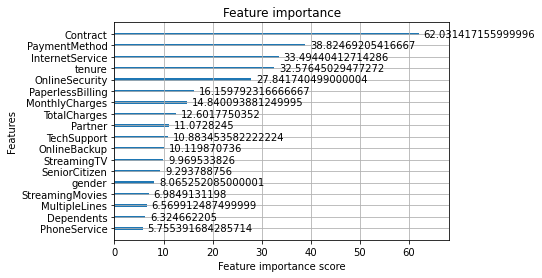

In [17]:
# non-normalized feature importance
xgb.plot_importance(clf.best_estimator_, importance_type = "gain", xlabel = "Feature importance score")

#### Model Results

In [18]:
print("Training recall: ", metrics.recall_score(y_train, train_pred))
print("Validation recall: ", metrics.recall_score(y_valid, val_pred))

print("\n")

print("Training precision: ", metrics.precision_score(y_train, train_pred))
print("Validation precision: ", metrics.precision_score(y_valid, val_pred))

print("\n")

print("Training accuracy: ", metrics.accuracy_score(y_train, train_pred))
print("Validation accuracy: ", metrics.accuracy_score(y_valid, val_pred))

print("\n")

y_train_prob = clf.predict_proba(X_train)
y_val_prob = clf.predict_proba(X_valid)

fpr, tpr, thresholds = metrics.roc_curve(y_train,
                                         y_train_prob[:, 1],
                                         pos_label=1)
print("Training AUC: ", metrics.auc(fpr, tpr))

fpr, tpr, thresholds = metrics.roc_curve(y_valid,
                                         y_val_prob[:, 1],
                                         pos_label=1)
print("Validation AUC: ", metrics.auc(fpr, tpr))

Training recall:  0.5340109460516028
Validation recall:  0.4915254237288136


Training precision:  0.683
Validation precision:  0.6697459584295612


Training accuracy:  0.8148073022312373
Validation accuracy:  0.7903454803596782


Training AUC:  0.8630443660513502
Validation AUC:  0.8423500673292009
